# Transformers for time-series processing

In this notebook, we play with the Jena Climate dataset [1]. We focus on a single-variable (univariate) time series and pick the temperature reading for building a forecasting model. We start with a recap of the RNN model as a baseline and then proceed to design basic transformer architecture suitable for time-series forecasting. There are usually many hyperparameters one needs to be aware of to unleash its' powers. Thus, the practical tasks would focus on tweaking those parameters and altering the architecture until the results astound you.


__References__
1. Jena Climate Dataset, https://www.kaggle.com/datasets/mnassrib/jena-climate


In [ ]:
# PyTorch Lightning
try:
    import pytorch_lightning as pl
    assert pl.__version__ == '1.9.4', "old version"
except Exception: # Google Colab does not have PyTorch Lightning
                            # installed by default.
                            # Hence, we do it here if necessary
    !pip install pytorch-lightning==1.9.4 
    import pytorch_lightning as pl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.9 MB/s eta 0:00:00


In [ ]:
import math
from time import time
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
from IPython.display import display

# Sklearn & stats tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Neural Networks
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
# from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = 18, 8


if torch.cuda.is_available():
    gpus = 1
else:
    gpus = 0

## Data


### Load

In [ ]:
!if [[ ! -f jena_climate_2009_2016.csv.zip ]] ; then wget -nc "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip" ; fi

--2023-04-08 09:55:04--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2023-04-08 09:55:05 (126 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [ ]:
data = pd.read_csv("jena_climate_2009_2016.csv.zip")
data = data.iloc[::144] # grab only 144th point (i.e., daily reading)
date_time_key = "Date Time"
data[date_time_key] = pd.to_datetime(data[date_time_key], infer_datetime_format=True)
data.set_index(date_time_key, inplace=True)
data.sort_index(inplace=True)
data.head()



,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.520,-8.020,265.400,-8.900,93.300,3.330,3.110,0.220,1.940,3.120,"1,307.750",1.030,1.750,152.300
2009-01-02 00:10:00,989.750,-3.010,270.950,-5.090,85.400,4.890,4.180,0.710,2.630,4.220,"1,274.230",3.630,4.880,26.730
2009-01-03 00:10:00,986.690,5.420,279.650,5.050,97.400,8.990,8.760,0.230,5.540,8.880,"1,229.690",0.800,1.500,177.300
2009-01-04 00:10:00,994.630,3.050,276.640,-0.480,77.500,7.610,5.900,1.710,3.700,5.930,"1,251.620",0.350,0.630,118.500
2009-01-05 00:10:00,992.960,9.660,283.390,8.630,93.300,12.020,11.210,0.810,7.050,11.290,"1,217.850",0.700,1.130,138.800


### Choose two columns

Further studies will be carried out with the temperature and pressure columns: `T (degC)`, `p (mbar)`.

In [ ]:
# Weather data
column_names = ["T (degC)", "p (mbar)"]
X = data[column_names].values
N = 7 * len(X) // 8  # approximately 1 year for testing

X_train, X_test = X[:N], X[N:]
print(X_train[0])


[ -8.02 996.52]


### Train/test split and preprocessing

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

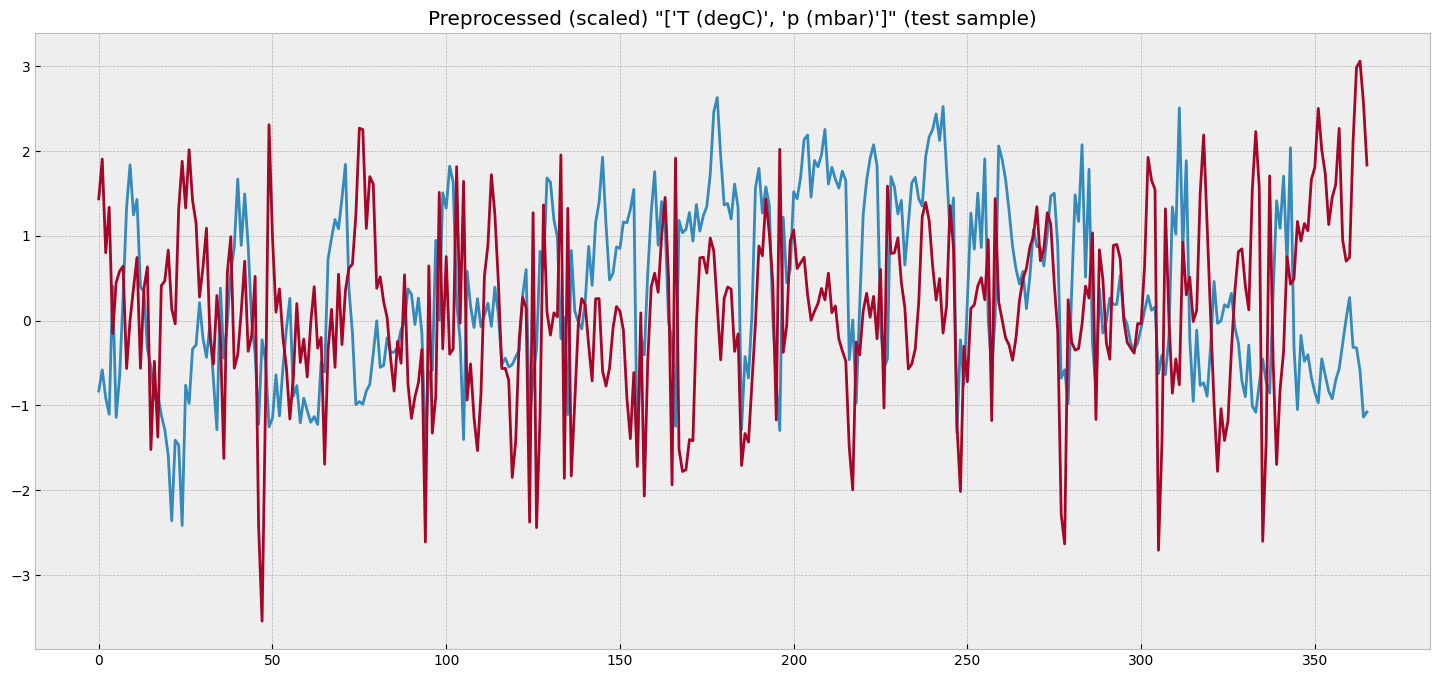

In [ ]:
# plt.plot(scaler.inverse_transform(X_test))
plt.plot(X_test)
plt.title(f'Preprocessed (scaled) "{column_names}" (test sample)');

### Preparing to feed the data to PyTorch models

The following function helps translate univariate time series into a tuple of arrays
- series of sequences of the given length
- target values that are shifted by the given number of steps from the beginning of the corresponding sequence

Such tuple is frequently used for building auto-regressive models, thus the function's name.

__Input X shape__: (n, p)<br>
__Ouput shapes__: (n - seq - tx + 1, seq, p), (n - seq - tx + 1, tx, p)

i.e., it concats each subsequence of `seq` elements into a single vector of `p`-dimensional vector features into `X`, and concats `tx` next elements into a `Y`.
One can interpret the output as an `seq`-dimensional encoding of each given measurement. Sometimes it is called a _delayed-coordinate_ representation or _auto-regressive_ (AR) representation.

In [ ]:
def AR_matrices(X, seq=1, tx=1, shift=1):
    # returns auto-regressive matrices for X with shape (seq, n) 
    # X_AR: (len(X) - seq, seq, element_len)
    # Y_AR: (len(X) - seq, element_len)
    # Y[i] is [tx * element_len] vector next (shift-1) after X[i:i+n]
    X_AR = []
    Y_AR = []
    seq_len, n_features = X.shape
    new_seq_len = seq_len - seq - tx + 1
    for i in range(seq, len(X) - shift - (tx - 1) + 1, shift):
        ax_ar = X[i - seq:i].reshape(-1, seq, n_features)
        X_AR.append(ax_ar)
        ay_ar = X[i + shift - 1:i + shift + tx - 1].reshape(tx, n_features)
        Y_AR.append(ay_ar)
    X_AR_arr = np.array(X_AR).reshape(-1, seq, n_features)
    Y_AR_arr = np.array(Y_AR).reshape(-1, tx, n_features)
    assert X_AR_arr.shape[0] == Y_AR_arr.shape[0], "X and Y shapes mismatch"
    assert X_AR_arr.shape[0] == new_seq_len, f"X shape mismatch: {X_AR_arr.shape[0]} != {new_seq_len}"
    assert X_AR_arr.shape[1] == seq, "X shape mismatch"
    assert Y_AR_arr.shape[1] == tx, "Y shape mismatch"
    if Y_AR_arr.shape[1] == 1:
        Y_AR_arr = Y_AR_arr.squeeze(axis=1)
    return X_AR_arr, Y_AR_arr


temp_X = np.concatenate([np.arange(7).reshape(-1, 1), np.arange(7, 0, -1).reshape(-1, 1)], axis=1)

temp_XAR, temp_YAR = AR_matrices(temp_X, seq=3, tx=3, shift=1)
print("Example: input shape:", temp_X.shape, '-> X:', temp_XAR.shape, "y:", temp_YAR.shape)
print(temp_X, '-> \nX:', temp_XAR, "\ny:", temp_YAR)
print("e.g.", temp_XAR[0], '->', temp_YAR[0])

Example: input shape: (7, 2) -> X: (2, 3, 2) y: (2, 3, 2)
[[0 7]
 [1 6]
 [2 5]
 [3 4]
 [4 3]
 [5 2]
 [6 1]] -> 
X: [[[0 7]
  [1 6]
  [2 5]]

 [[1 6]
  [2 5]
  [3 4]]] 
y: [[[3 4]
  [4 3]
  [5 2]]

 [[4 3]
  [5 2]
  [6 1]]]
e.g. [[0 7]
 [1 6]
 [2 5]] -> [[3 4]
 [4 3]
 [5 2]]



We define a custom `torch.util.data.Dataset` subclass to transform source time series (`X` and `y`) to PyTorch models such as RNNs and Transformer in sequences of `seq_len` and `target_len` lengths.

In [ ]:
class TimeseriesDataset(Dataset):   
    def __init__(self, X: np.ndarray, y: np.ndarray=None,
                 reshape_features=None):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float() if y is not None else None
        self.len, self.seq_len, self.n_features = self.X.shape
        self.new_n_features = self.n_features if reshape_features is None else reshape_features

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x = self.X[index].reshape(-1, self.new_n_features)
        if self.y is not None:
            y = self.y[index].squeeze()
            return x, y  # TODO check if works with LSTM or squeeze it?
        else:
            return x

In [ ]:
X_train_, y_train_ = AR_matrices(X_train[:100], seq=4, tx=2, shift=1)
print(X_train_[:5], y_train_[:5])
dataset = TimeseriesDataset(X_train_, y_train_, reshape_features=4)
X_0, y_0 = dataset[0]
print(X_0, y_0)

[[[-2.05726901  0.87403891]
  [-1.42830142  0.05512202]
  [-0.36997871 -0.31502357]
  [-0.66751428  0.64541957]]

 [[-1.42830142  0.05512202]
  [-0.36997871 -0.31502357]
  [-0.66751428  0.64541957]
  [ 0.16232121  0.44341201]]

 [[-0.36997871 -0.31502357]
  [-0.66751428  0.64541957]
  [ 0.16232121  0.44341201]
  [ 0.50128578  0.57405163]]

 [[-0.66751428  0.64541957]
  [ 0.16232121  0.44341201]
  [ 0.50128578  0.57405163]
  [ 1.18423661  0.53413397]]

 [[ 0.16232121  0.44341201]
  [ 0.50128578  0.57405163]
  [ 1.18423661  0.53413397]
  [ 0.55024732  0.61155004]]] [[[ 0.16232121  0.44341201]
  [ 0.50128578  0.57405163]]

 [[ 0.50128578  0.57405163]
  [ 1.18423661  0.53413397]]

 [[ 1.18423661  0.53413397]
  [ 0.55024732  0.61155004]]

 [[ 0.55024732  0.61155004]
  [ 0.56029072 -0.00656891]]

 [[ 0.56029072 -0.00656891]
  [ 0.59293175 -0.36219899]]]
tensor([[-2.0573,  0.8740, -1.4283,  0.0551],
        [-0.3700, -0.3150, -0.6675,  0.6454]]) tensor([[0.1623, 0.4434],
        [0.5013, 0.57

In [ ]:
print(len(dataset), '\nDS[0]:', dataset[0], "\n", dataset[0][0].shape, dataset[0][1].shape)

95 
DS[0]: (tensor([[-2.0573,  0.8740, -1.4283,  0.0551],
        [-0.3700, -0.3150, -0.6675,  0.6454]]), tensor([[0.1623, 0.4434],
        [0.5013, 0.5741]])) 
 torch.Size([2, 4]) torch.Size([2, 2])


In [ ]:
y_0

tensor([[0.1623, 0.4434],
        [0.5013, 0.5741]])

In [ ]:
y_0[:,1].shape

torch.Size([2])

`SequenceDataModule` inherits `pl.LightningDataModule` to provide `Trainer` with properly constructed `X` batches of (`batch_size` x `seq_len` x `n_features`) and `Y` batches of (`batch_size` x `tgt_len` x `n_features`).

Details: https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html

In [ ]:
class SequenceDataModule(pl.LightningDataModule):
    def __init__(self, X_train, X_test, seq_len=1, batch_size=128, target_len=1,
                 num_workers=0, shift=1, reshape_features=None, train_size=0.6):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers

        N = int(train_size * len(X_train))

        self.X_train, self.y_train = AR_matrices(X_train[:N], seq=seq_len, tx=target_len, shift=shift)
        self.X_val, self.y_val = AR_matrices(X_train[N:], seq=seq_len, tx=target_len, shift=shift)
        self.X_test, self.y_test = AR_matrices(X_test, seq=seq_len, tx=target_len, shift=shift)
        
        self.train_dataset = TimeseriesDataset(self.X_train, self.y_train, 
                                               reshape_features=reshape_features)
        self.val_dataset = TimeseriesDataset(self.X_val, self.y_val, 
                                             reshape_features=reshape_features)
        self.test_dataset = TimeseriesDataset(self.X_test, self.y_test,
                                              reshape_features=reshape_features)
        self.predict_dataset = TimeseriesDataset(self.X_test, reshape_features=reshape_features)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = True,
                                  num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                                batch_size = self.batch_size, 
                                shuffle = False,
                                num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                                 batch_size = self.batch_size, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, 
                            batch_size = self.batch_size, 
                            shuffle = False, 
                            num_workers = self.num_workers)

In [ ]:
# Aux training classes/functions

class LitProgressBar(pl.callbacks.TQDMProgressBar):
    def init_sanity_tqdm(self):
        return tqdm(disable=True)
    
    def init_validation_tqdm(self):
        return tqdm(disable=True)
    
    def init_predict_tqdm(self):
        return tqdm(disable=True)

    def get_metrics(self, trainer, model):
        # hide the version number
        items = super().get_metrics(trainer, model)
        items.pop("v_num", None)
        return items
    
def mat2vec(bT):
    t = bT.shape[1]
    bpad = np.pad(bT, ((0,t-1), (0,0)), mode='constant', constant_values=np.nan)
    bpadT = bpad.T.reshape(t,-1)
    concat_shift = np.concatenate([np.roll(bpadT[i], i).reshape(1,-1) for i in range(t)], axis=0)
    return np.nanmean(concat_shift, axis=0)

def plot_test_predict(y, y_hat, scaler=scaler, kind='series'):
    plt.figure(figsize=(18, 7))
    len_y = y.shape[0]
    n_features = y.shape[-1]
    seq = 1 if len(y.shape) == 2 else y.shape[1]
    y_feature_true = np.zeros((n_features, len_y + seq - 1))
    y_feature_pred = np.zeros((n_features, len_y + seq - 1))
    if len(y.shape) == 3:
        seq = y.shape[1]
        for i in range(n_features):
            y_feature_true[i] = mat2vec(y[:,:,i])
            y_feature_pred[i] = mat2vec(y_hat[:,:,i])
    elif len(y.shape) == 2:
        for i in range(n_features):
            y_feature_true[i] = y[:, i]
            y_feature_pred[i] = y_hat[:, i]
    if scaler:
        y = scaler.inverse_transform(y_feature_true.transpose((1,0)))
        y_hat = scaler.inverse_transform(y_feature_pred.transpose((1,0)))
    y = y.transpose((1,0))
    y_hat = y_hat.transpose((1,0))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
    for i in range(n_features):
        mae_i = np.mean(np.abs(y[i] - y_hat[i]))
        if kind == 'series':
            axes[i].plot(y[i], label='True', alpha=0.5)
            axes[i].plot(y_hat[i], label='Prediction', alpha=0.5)
            plt.legend(loc='best', fontsize=14)
        elif kind == 'scatter':
            axes[i].plot(y[i], y_hat[i], 'o', alpha=0.4)
            axes[i].plot([y[i].min(), y[i].max()], [y[i].min(), y[i].max()], 'k--', lw=4)
        axes[i].set_title(f"Feature {i+1}, mae: {mae_i:.2f}")
    
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.grid(visible=1)
    print(f'MAE loss (sklearn), unscaled: {mae(y, y_hat):.2f}')

def plot_training_metrics(logger):
    filename = f"{logger.log_dir}/metrics.csv"
    metrics = pd.read_csv(filename)
    train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
    val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]

    fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
    axes[0].set_title('Train loss per epoch')
    axes[0].plot(train_loss['epoch'], train_loss['train_loss'])
    axes[1].set_title('Validation loss per epoch')
    axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
    plt.show(block = True)

    print('MSE:')
    print(f"\tTrain loss: {train_loss['train_loss'].iloc[-1]:.3f}")
    print(f"\tVal loss:   {val_loss['val_loss'].iloc[-1]:.3f}")

# pytorch model parameter statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'The model has {count_parameters(lstm_model):,} trainable parameters')

# LSTM model

Resurrect a recurrent neural network to address the forecasting problem.

In [ ]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 hidden_size=10, 
                 input_size=1,
                 seq_len=1, 
                 batch_size=16,
                 num_layers=1, 
                 dropout=0.1, 
                 learning_rate=1e-3,
                 criterion=nn.MSELoss,
                 target_len=1,
                ):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.val_mae = torchmetrics.MeanAbsoluteError()
        self.test_mae = torchmetrics.MeanAbsoluteError()

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, # number of LSTM-layers.
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, target_len * input_size)
        self.output_shape = (-1, target_len, input_size) if target_len > 1 else None
        
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        dropout_out = self.dropout(lstm_out[:,-1])
        y_pred = self.linear(dropout_out)
        if self.output_shape:
            return y_pred.view(self.output_shape)
        return y_pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def training_epoch_end(self, outputs):
        # outputs is a list of dicts
        mean_loss = torch.stack([l['loss'] for l in outputs]).mean()
        self.log('train_loss', mean_loss, prog_bar=True, on_step=False, on_epoch=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.val_mae.update(y_hat, y)
        return loss

    def validation_epoch_end(self, outputs):
        # outputs is a list of step losses
        self.log('val_loss', torch.mean(torch.stack(outputs)), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.test_mae.update(y_hat, y)
        return loss
    
    def test_epoch_end(self, outputs):
        self.log('test_loss', np.mean(outputs))

In [ ]:
lstm_param = dict(
    seq_len = 14, # number of sequence elements
    input_size = 2, # number of features per sequence element
    target_len = 2, # number of sequence element to predict
    hidden_size = 60,
    num_layers = 2,
    batch_size = 96,
    max_epochs = 100,
    dropout = 0.05,
    learning_rate = 1e-3,
    # criterion = nn.MSELoss(),
    criterion = nn.L1Loss()
)

In [ ]:
lstm_dm = SequenceDataModule(
    X_train,
    X_test,
    seq_len = lstm_param['seq_len'],
    batch_size = lstm_param['batch_size'],
    target_len = lstm_param['target_len'])  

In [ ]:
# check batches
dl = lstm_dm.train_dataloader()
for xb, yb in dl:
  break

print("X element:", xb[0], "\nY element:", yb[0], "\nlengths:", len(xb[0]), len(yb[0]), xb.shape, yb.shape, len(dl), len(X_train))

X element: tensor([[ 0.9231, -0.8460],
        [-0.1026,  0.1120],
        [-0.1252, -1.9589],
        [-0.7993, -0.6779],
        [-0.2997, -0.1953],
        [-0.7140,  0.5837],
        [-0.1980,  0.0092],
        [-0.3424,  1.4655],
        [-0.3599,  1.8381],
        [-0.7303,  1.9361],
        [-0.6010,  1.1208],
        [-1.1019,  1.5659],
        [-1.3304,  1.7595],
        [-1.0479,  0.8559]]) 
Y element: tensor([[-0.2758,  0.1809],
        [-0.9299, -2.1899]]) 
lengths: 14 2 torch.Size([96, 14, 2]) torch.Size([96, 2, 2]) 16 2555


In [ ]:
seed_everything(1)
lstm_model = LSTMRegressor(
    input_size = lstm_param['input_size'],
    hidden_size = lstm_param['hidden_size'],
    target_len = lstm_param['target_len'],
    seq_len = lstm_param['seq_len'],
    batch_size = lstm_param['batch_size'],
    criterion = lstm_param['criterion'],
    num_layers = lstm_param['num_layers'],
    dropout = lstm_param['dropout'],
    learning_rate = lstm_param['learning_rate'],
)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
lstm_trainer = Trainer(
    max_epochs=lstm_param['max_epochs'],
    logger=CSVLogger('./logs', name='lstm', version='0'),
    gpus=gpus,
    log_every_n_steps=20,
    callbacks=[LitProgressBar(), EarlyStopping(monitor="val_loss", patience=20)],
)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training

In [ ]:
lstm_trainer.fit(lstm_model, datamodule=lstm_dm);

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory ./logs/lstm/0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | dropout   | Dropout           | 0     
1 | criterion | L1Loss            | 0     
2 | val_mae   | MeanAbsoluteError | 0     
3 | test_mae  | MeanAbsoluteError | 0     
4 | lstm      | LSTM              | 44.6 K
5 | linear    | Linear            | 244   
------------------------------------------------
44.9 K    Trainable params
0         Non-trainable params
44.9 K    Total params
0.180     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/lightning_fabric/loggers/csv_logs.py:183: UserW

Training: 0it [00:00, ?it/s]

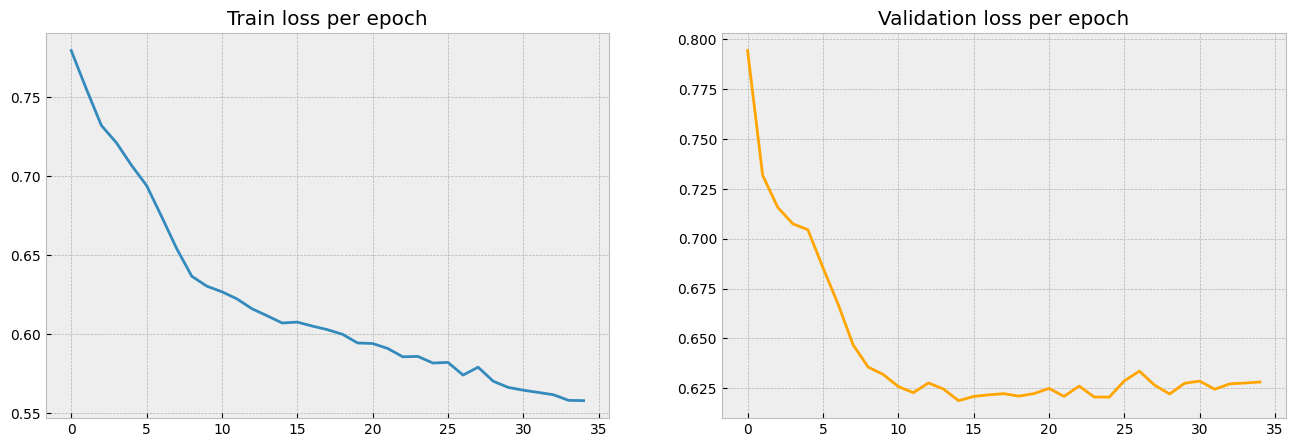

MSE:
	Train loss: 0.558
	Val loss:   0.628


In [ ]:
plot_training_metrics(lstm_trainer.logger)

## Testing / Prediction

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


true: tensor([[-0.3336, -0.5508],
        [-0.5508, -0.9299],
        [-0.9299, -0.8659],
        [-0.8659, -1.1144],
        [-1.1144, -1.2852],
        [-1.2852, -1.5915],
        [-1.5915, -2.3598],
        [-2.3598, -1.4095],
        [-1.4095, -1.4685],
        [-1.4685, -2.4151],
        [-2.4151, -0.7629],
        [-0.7629, -0.9763],
        [-0.9763, -0.3361],
        [-0.3361, -0.2871],
        [-0.2871,  0.2100],
        [ 0.2100, -0.2118],
        [-0.2118, -0.4327],
        [-0.4327, -0.0486],
        [-0.0486, -0.6989],
        [-0.6989, -1.2864],
        [-1.2864,  0.3820],
        [ 0.3820, -0.4440],
        [-0.4440, -0.0185],
        [-0.0185,  0.5804],
        [ 0.5804,  0.8628],
        [ 0.8628,  1.6676],
        [ 1.6676,  0.8854],
        [ 0.8854,  1.4918],
        [ 1.4918,  0.8792],
        [ 0.8792,  0.0054],
        [ 0.0054, -0.3926],
        [-0.3926, -1.2237],
        [-1.2237, -0.2269],
        [-0.2269, -0.4754],
        [-0.4754, -1.2525],
        [-1.25

<Figure size 1800x700 with 0 Axes>

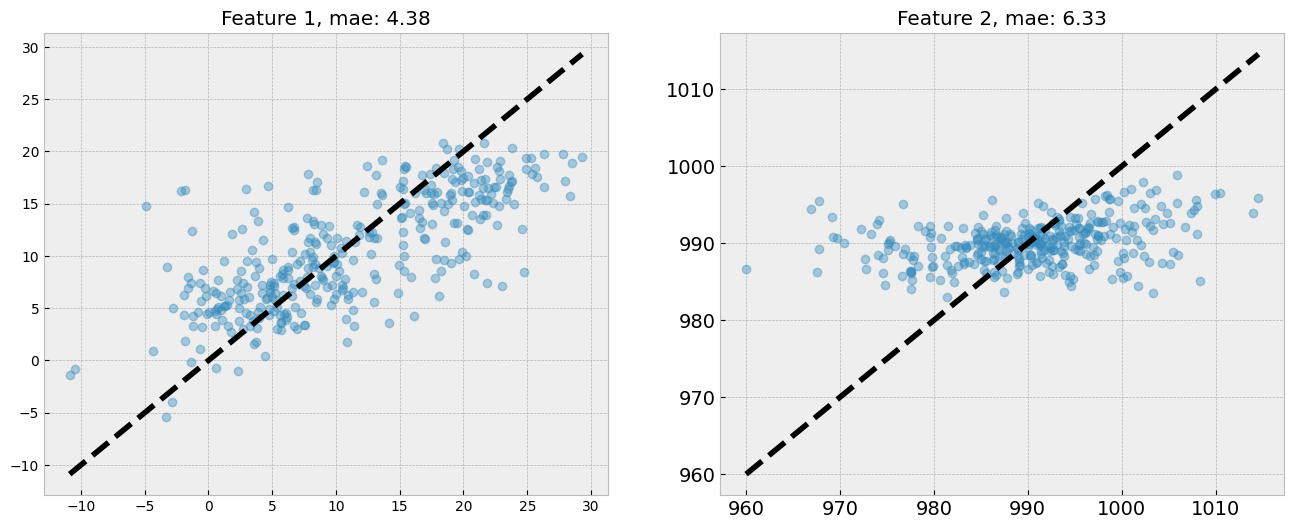

In [ ]:
_, y = map(torch.cat, zip(*lstm_dm.test_dataloader()))
y_hat = torch.cat(lstm_trainer.predict(lstm_model, lstm_dm))
plot_test_predict(y, y_hat, kind='scatter');

# Time series Transformer, basic implementation

In [ ]:
class TSTransformerVanilla(pl.LightningModule):
    # d_model : number of features in the input
    def __init__(self, n_features=1, num_layers=3, num_heads=7, dim_feedforward=2048,
                 dropout=0, learning_rate=1e-3, seq_len=8, 
                 target_len=1, target_n_features=1,
                 criterion=nn.MSELoss()):
        super(TSTransformerVanilla, self).__init__()

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=n_features,
                                                        nhead=num_heads,
                                                        dim_feedforward=dim_feedforward,
                                                        dropout=dropout,
                                                        batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, 
                                                         num_layers=num_layers)        
        self.seq_len = seq_len
        self.output_shape = (-1, target_len, target_n_features) if target_len > 1 else (-1, target_n_features)
        output_size = target_len * target_n_features

        self.decoder = self.create_decoder(n_features * seq_len, c_out=output_size, dropout=dropout)
        self.learning_rate = learning_rate
        self.mask = self._generate_square_subsequent_mask(self.seq_len)
        # self.mask = None
        self.init_weights()
        self.criterion = criterion
        self.val_mae = torchmetrics.MeanAbsoluteError()
        self.test_mae = torchmetrics.MeanAbsoluteError()
        self.encoder_dropout = nn.Dropout(dropout)

    def create_decoder(self, ndim, c_out=1, dropout=0):
        layers = [nn.Flatten()]
        if dropout:
            layers += [nn.Dropout(dropout)]
        layers += [nn.Linear(ndim, c_out)]
        return nn.Sequential(*layers)

    @torch.no_grad()
    def init_weights(self, initrange=1e-4):
        def _init(m):
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if hasattr(m, 'bias') and m.bias is not None:
                    nn.init.normal_(m.bias, std=initrange)            
        self.apply(_init)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        assert src.shape[1] == self.seq_len, ">> incorrect sequence len: got {} vs exp {}".format(src.shape[1], self.seq_len)
        src_dropout = self.encoder_dropout(src)
        output = self.transformer_encoder(src_dropout, mask=self.mask)
        output = self.decoder(output)
        return output.view(self.output_shape)

    def configure_optimizers(self):
        if self.mask is not None and self.mask.device != self.device:
            self.mask = self.mask.to(self.device)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.33, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)
        # return dict(optimizer=optimizer, 
        #             lr_scheduler=dict(scheduler=scheduler, monitor='val_loss', frequency=1, interval="epoch"))
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def training_epoch_end(self, outputs):
        # outputs is a list of dicts
        mean_loss = torch.stack([l['loss'] for l in outputs]).mean()
        self.log('train_loss', mean_loss, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.val_mae.update(y_hat, y)
        return loss

    def validation_epoch_end(self, outputs):
        # outputs is a list of step losses
        self.log('val_loss', torch.mean(torch.stack(outputs)), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.test_mae.update(y_hat, y)
        return loss
    
    def test_epoch_end(self, outputs):
        self.log('test_loss', np.mean(outputs))


In [ ]:
tfr_param = dict(
                seq_len = 28, # number of elements in raw input sequence
                target_len = 7, # how many elements to predict
                target_n_features = 2, # number of features in target
                reshape_seq_len = 14, # new seq_len
                reshape_features = 4, # new n_features, must be divisible by num_heads
                dim_feedforward = 1024,
                num_heads = 4,
                num_layers = 3,
                max_epochs = 100,
                batch_size = 96,
                # criterion = nn.MSELoss(),
                criterion = nn.L1Loss(),
                dropout = 0.05,
                learning_rate = 1e-3,
                )

In [ ]:
tfr_dm = SequenceDataModule(
    X_train,
    X_test,
    seq_len = tfr_param['seq_len'],
    batch_size = tfr_param['batch_size'],
    target_len=tfr_param['target_len'],
    reshape_features=tfr_param['reshape_features'],
    )

In [ ]:
X_train[:10]

array([[-2.05726901,  0.87403891],
       [-1.42830142,  0.05512202],
       [-0.36997871, -0.31502357],
       [-0.66751428,  0.64541957],
       [ 0.16232121,  0.44341201],
       [ 0.50128578,  0.57405163],
       [ 1.18423661,  0.53413397],
       [ 0.55024732,  0.61155004],
       [ 0.56029072, -0.00656891],
       [ 0.59293175, -0.36219899]])

In [ ]:
# check batches
dl = tfr_dm.train_dataloader()
for xb, yb in dl:
  break

# assert np.allclose(yb[0], X_train[tfr_dm.n_features + tfr_dm.seq_len -1])
print("X0 element:", xb[0], "\nY0 element:", yb[0], "\nX1:", xb[1], "\nshapes:", xb.shape, yb.shape, len(dl), len(X_train))

X0 element: tensor([[-1.6103,  0.2874, -0.6562, -0.4432],
        [-0.1352, -0.4541, -0.2570,  1.0204],
        [ 0.4511,  0.8692,  0.5942, -0.1094],
        [ 0.9306,  0.1398,  0.7436,  0.2341],
        [ 1.3173, -0.5049,  0.8804, -0.1384],
        [-0.6863,  1.1825, -1.1170,  0.0817],
        [-1.1998,  2.2772, -1.4082,  1.7994],
        [-1.5262,  1.0760, -1.4509,  1.1353],
        [-1.4245,  0.8680, -1.1647,  0.9986],
        [-0.6700,  0.8571, -1.0015,  0.8982],
        [-0.5344,  0.5341, -0.8081,  0.2898],
        [-0.9688,  0.8704, -1.0015,  1.7474],
        [-1.1697,  1.6869, -0.6713,  1.2611],
        [-0.4428,  0.8825, -0.2206,  1.0204]]) 
Y0 element: tensor([[-1.3304,  1.0664],
        [-0.6349,  0.3007],
        [-0.6487, -0.6598],
        [-0.6876, -0.1650],
        [-0.6876,  0.1567],
        [ 0.2552, -0.3174],
        [ 0.4046,  0.3358]]) 
X1: tensor([[-0.8922,  0.9962, -1.0027, -0.2884],
        [-1.1772,  0.1846, -0.5809, -0.6428],
        [-0.0724, -0.7505,  0.5327, 

In [ ]:
seed_everything(1)
tfr_model = TSTransformerVanilla(n_features=tfr_param['reshape_features'],
                                num_heads=tfr_param['num_heads'],
                                num_layers=tfr_param['num_layers'],
                                seq_len=tfr_param['reshape_seq_len'],
                                dim_feedforward=tfr_param['dim_feedforward'],
                                target_len=tfr_param['target_len'],
                                target_n_features=tfr_param['target_n_features'],
                                learning_rate=tfr_param['learning_rate'],
                                dropout=tfr_param['dropout'],
                                criterion=tfr_param['criterion'],
                                )

INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [ ]:
tfr_trainer = pl.Trainer(
    max_epochs=tfr_param['max_epochs'],
    gpus=gpus,
    # fast_dev_run=True,  # comment in to check that the dataset has no serious bugs
    callbacks=[LitProgressBar(), EarlyStopping(monitor="val_loss", patience=15)],
    log_every_n_steps=20,
    logger=CSVLogger('logs', name='transformer', version='vanilla')
    )

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training

In [ ]:
tfr_trainer.fit(
    tfr_model,
    datamodule=tfr_dm);


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                    | Params
----------------------------------------------------------------
0 | encoder_layer       | TransformerEncoderLayer | 9.3 K 
1 | transformer_encoder | TransformerEncoder      | 27.9 K
2 | decoder             | Sequential              | 798   
3 | criterion           | L1Loss                  | 0     
4 | val_mae             | MeanAbsoluteError       | 0     
5 | test_mae            | MeanAbsoluteError       | 0     
6 | encoder_dropout     | Dropout                 | 0     
----------------------------------------------------------------
38.1 K    Trainable params
0         Non-trainable params
38.1 K    Total params
0.152     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool

Training: 0it [00:00, ?it/s]

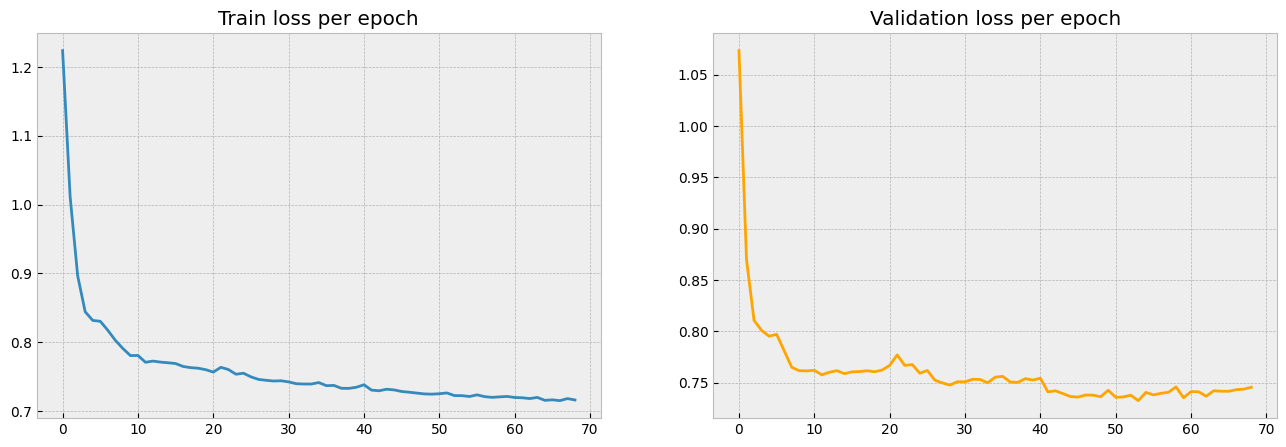

MSE:
	Train loss: 0.716
	Val loss:   0.745


In [ ]:

plot_training_metrics(tfr_trainer.logger)

## Testing / Prediction

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE loss (sklearn), unscaled: 6.48


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


<Figure size 1800x700 with 0 Axes>

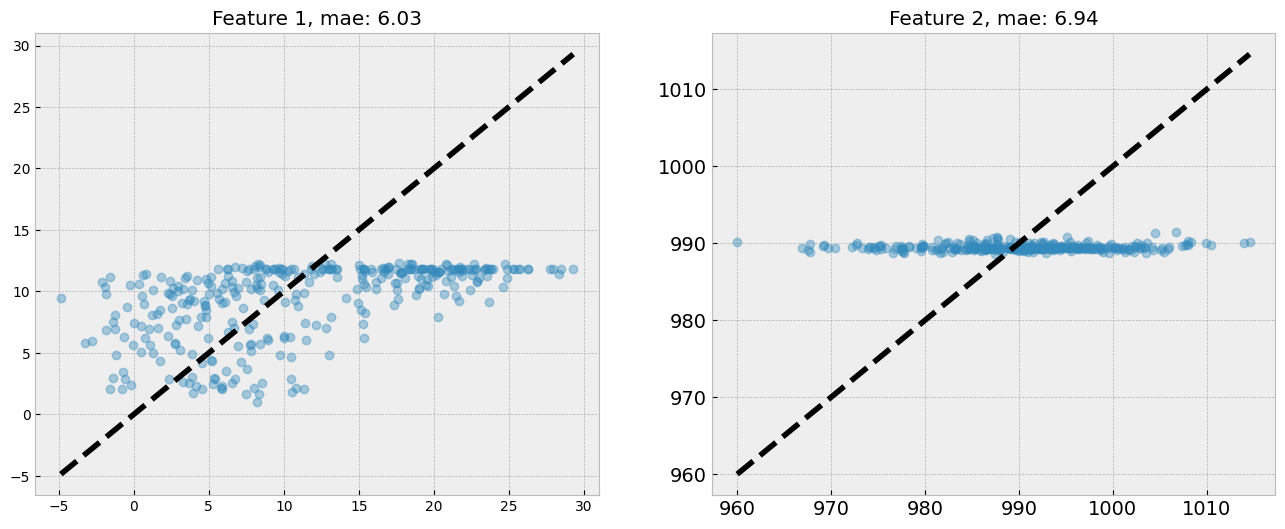

In [ ]:
_, y = map(torch.cat, zip(*tfr_dm.test_dataloader()))
y_hat = torch.cat(tfr_trainer.predict(tfr_model, tfr_dm))
plot_test_predict(y, y_hat, kind='scatter')

# Transformer + Positional Encoding

## Positional encoding (recap)

Reminder of positional encoding formula:
$$\overrightarrow{p_{t}}^{(i)}=f(t)^{(i)}:= \begin{cases}\sin \left(\omega_{k} \cdot t\right), & \text { if } i=2 k \\ \cos \left(\omega_{k} \cdot t\right), & \text { if } i=2 k+1\end{cases}$$

where

$$\omega_{k}=\frac{1}{10000^{2 k / d}}, k \in [0, d/2)$$
$$t - \textrm{element index in a sequence}$$
$$i - \textrm{index of a feature} \in [0,..,d)$$

In [ ]:
# Once given those parameters, one can construct a tensor with this encoding
seq_len = 4
d_model = 7
max_div = 2e2

pe = torch.zeros(seq_len, d_model)  # positional encoding
position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
div_term_sin = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(max_div) / d_model))
div_term_cos = torch.exp(torch.arange(1, d_model, 2).float() * (-math.log(max_div) / d_model))
pe[:, 0::2] = torch.sin(position * div_term_sin)
pe[:, 1::2] = torch.cos(position * div_term_cos)
print("Debug, div_term_sin", div_term_sin)

pe = pe - pe.mean()
pe = pe / pe.std()

Debug, div_term_sin tensor([1.0000, 0.2201, 0.0484, 0.0107])


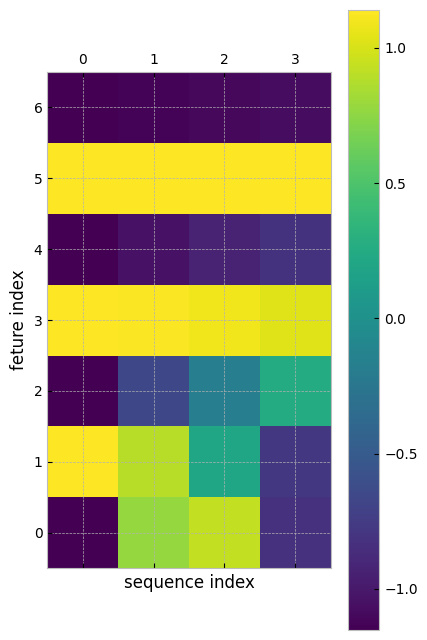

In [ ]:

plt.matshow(pe.numpy().T, origin='lower')
plt.colorbar()
plt.xlabel("sequence index")
plt.ylabel("feture index");

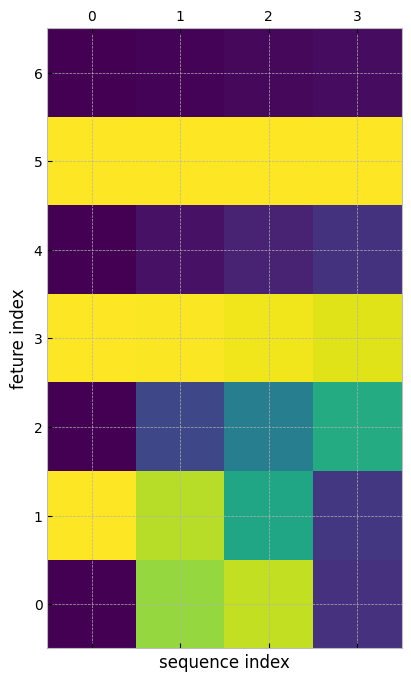

In [ ]:
plt.matshow(pe.numpy().T, origin='lower')
plt.xlabel("sequence index")
plt.ylabel("feture index");

In [ ]:
def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / cpe.std()
        cpe = cpe / 10
    return cpe

cpe = Coord2dPosEncoding(seq_len, d_model, exponential=True, normalize=True)

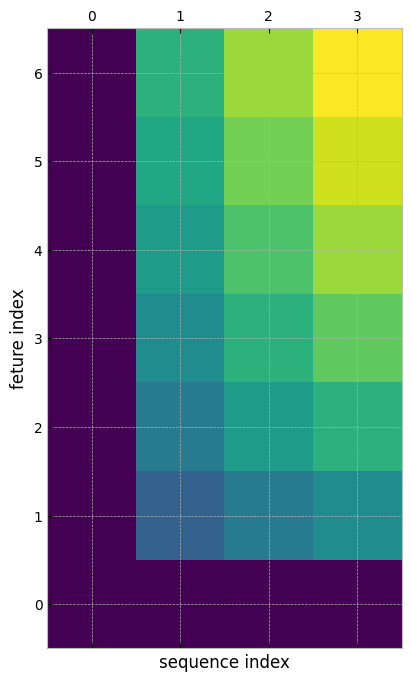

In [ ]:
plt.matshow(cpe.numpy().T, origin='lower')
plt.xlabel("sequence index")
plt.ylabel("feture index");

## Task 1 (Score: 2)

Implement sincos inside PositionalEncoding method following the logic above 

In [ ]:
def PositionalEncoding(q_len, d_model, normalize=True, max_div=1e4): # TODO: define device
    pe = torch.zeros(q_len, d_model)
    # implement sin/cos positional encoding, and add save it to `pe` tensor
    
    # <YOUR CODE>
    # raise NotImplementedError # <= remove this


    if normalize:
        pe = pe - pe.mean()
        pe = pe / pe.std()
        pe = pe / 10
    return pe

In [ ]:
class TSTransformerPositional(TSTransformerVanilla):
    # d_model : number of features
    def __init__(self, feature_size=1, num_layers=3, num_heads=7, dim_feedforward=2048,
                 dropout=0, learning_rate=1e-3, seq_len=8, target_len=1, target_n_features=1,
                 criterion=nn.MSELoss()):
        super(TSTransformerPositional, self).__init__(n_features=feature_size,
                                                      num_layers=num_layers,
                                                      num_heads=num_heads,
                                                      dim_feedforward=dim_feedforward,
                                                      dropout=dropout,
                                                      learning_rate=learning_rate,
                                                      seq_len=seq_len,
                                                      target_len=target_len,
                                                      target_n_features=target_n_features,
                                                      criterion=criterion)

        # self.W_pos = self._positional_encoding(None, False, seq_len, feature_size)
        # self.W_pos = self._positional_encoding("zeros", True, seq_len, feature_size)
        # self.W_pos = self._positional_encoding("normal", True, seq_len, feature_size)
        # self.W_pos = self._positional_encoding("uniform", True, seq_len, feature_size)
        self.W_pos = self._positional_encoding("sincos", False, seq_len, feature_size, normalize=True, max_div=1e2)
        # self.W_pos = self._positional_encoding("sincos", True, seq_len, feature_size, normalize=False)
        # self.W_pos = self._positional_encoding("sincos", True, seq_len, feature_size, normalize=True)
        # self.W_pos = self._positional_encoding("lin2d", False, seq_len, feature_size,  normalize=False)
        # self.W_pos = self._positional_encoding("exp2d", False, seq_len, feature_size,  normalize=False)
        # self.W_pos = self._positional_encoding("exp2d", False, seq_len, feature_size,  normalize=True)
        self.dropout = nn.Dropout(dropout)

    def _positional_encoding(self, pe, learn_pe, q_len=1, d_model=1, normalize=True, max_div=1e4):
        if pe == None:
            W_pos = torch.zeros((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
            learn_pe = False
        elif pe == 'zeros':
            W_pos = torch.empty((q_len, d_model))
            nn.init.uniform_(W_pos, -0.02, 0.02)
        elif pe == 'normal' or pe == 'gauss':
            W_pos = torch.zeros((q_len, d_model))
            torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
        elif pe == 'uniform':
            W_pos = torch.zeros((q_len, d_model))
            nn.init.uniform_(W_pos, a=0.0, b=0.1)
        elif pe == 'lin2d': 
          W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=normalize)
        elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=normalize)
        elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=normalize, max_div=max_div)
        return nn.Parameter(W_pos, requires_grad=learn_pe)

    def forward(self, src):
        assert src.shape[1] == self.seq_len, "incorrect sequence len"
        src = self.dropout(src + self.W_pos)
        # src = src + self.W_pos
        output = self.transformer_encoder(src, mask=self.mask)
        output = self.decoder(output)
        return output.view(self.output_shape)



In [ ]:
tfr_pos_model = TSTransformerPositional(feature_size=tfr_param['reshape_features'],
                                        num_heads=tfr_param['num_heads'],
                                        num_layers=tfr_param['num_layers'],
                                        seq_len=tfr_param['reshape_seq_len'],
                                        dim_feedforward=tfr_param['dim_feedforward'],
                                        target_len=tfr_param['target_len'],
                                        target_n_features=tfr_param['target_n_features'],
                                        learning_rate=tfr_param['learning_rate'],
                                        dropout=tfr_param['dropout'],
                                        criterion=tfr_param['criterion'])

In [ ]:
# add early stop callback to pl.Trainer


seed_everything(1)
tfr_pos_trainer = pl.Trainer(
    max_epochs=tfr_param['max_epochs'],
    gpus=gpus,
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[LitProgressBar(), EarlyStopping(monitor="val_loss", patience=15)], # 
    log_every_n_steps = 20,
    logger=CSVLogger('logs', name='transformer', version='pos')
    )

tfr_pos_dm = SequenceDataModule(
    X_train,
    X_test,
    seq_len = tfr_param['seq_len'],
    batch_size = tfr_param['batch_size'],
    target_len=tfr_param['target_len'],
    reshape_features=tfr_param['reshape_features'],
    )

INFO:lightning_fabric.utilities.seed:Global seed set to 1
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training

In [ ]:
tfr_pos_trainer.fit(
    tfr_pos_model,
    datamodule=tfr_pos_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                    | Params
----------------------------------------------------------------
0 | encoder_layer       | TransformerEncoderLayer | 9.3 K 
1 | transformer_encoder | TransformerEncoder      | 27.9 K
2 | decoder             | Sequential              | 798   
3 | criterion           | L1Loss                  | 0     
4 | val_mae             | MeanAbsoluteError       | 0     
5 | test_mae            | MeanAbsoluteError       | 0     
6 | encoder_dropout     | Dropout                 | 0     
7 | dropout             | Dropout                 | 0     
----------------------------------------------------------------
38.1 K    Trainable params
56        Non-trainable params
38.1 K    Total params
0.152     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: Us

Training: 0it [00:00, ?it/s]

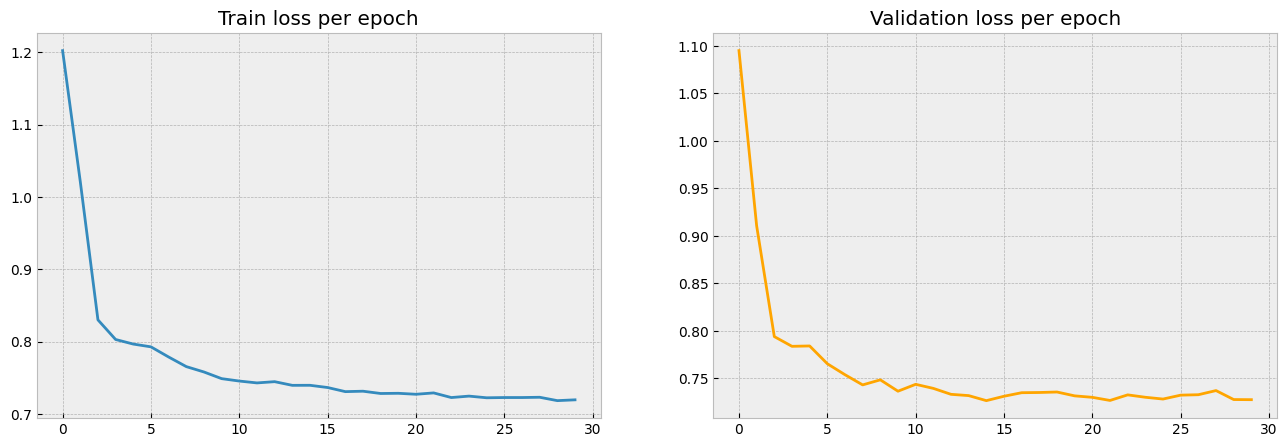

MSE:
	Train loss: 0.719
	Val loss:   0.728


In [ ]:
plot_training_metrics(tfr_pos_trainer.logger)

## Testing / Prediction

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


MAE loss (sklearn), unscaled: 6.35


<Figure size 1800x700 with 0 Axes>

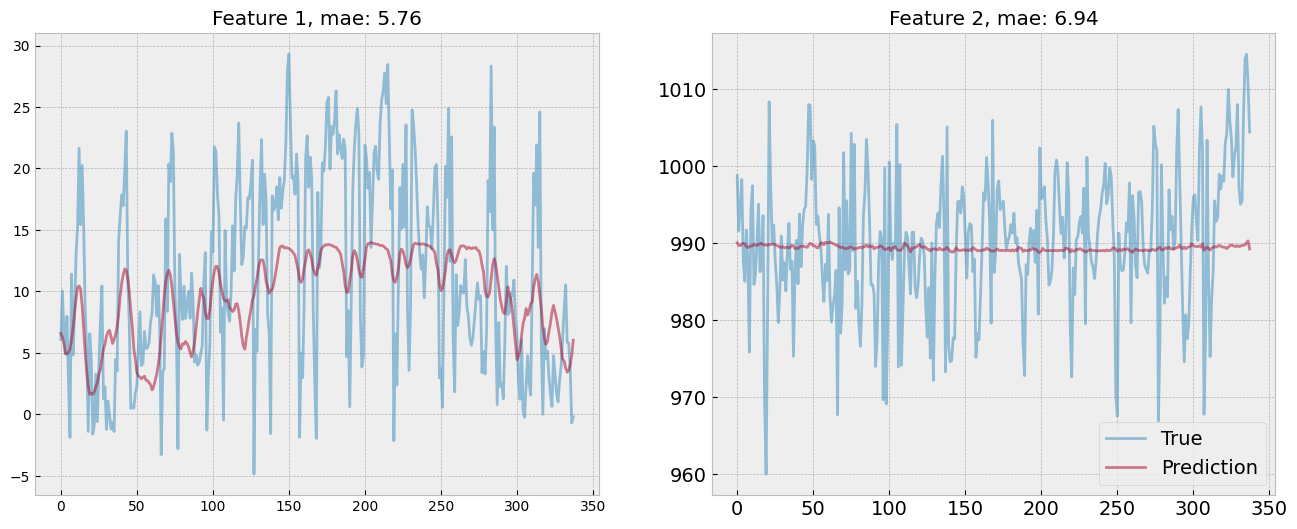

In [ ]:
_, y = map(torch.cat, zip(*tfr_pos_dm.test_dataloader()))
y_hat = torch.cat(tfr_pos_trainer.predict(tfr_pos_model, tfr_pos_dm))
plot_test_predict(y, y_hat)

## Task 2 (Score: 2)

Compare various positional encodings implemented above. Play with 'normalization' and 'learning' parameters.

Make a table with the test performance under similar computational budget. 

# Task 3 (Score: 2) TSTransformerPositionalCat

Implement `TSTransformerPositionalCat` so it concats positional encoding tensor to `src` instead of numerical adding. 

In [ ]:
class TSTransformerPositionalCat(TSTransformerPositional):
    # d_model : number of features
    def __init__(self, feature_size=1, num_layers=3, num_heads=7, dim_feedforward=2048,
                 dropout=0, learning_rate=1e-3, seq_len=8, target_len=1, target_n_features=1,
                 criterion=nn.MSELoss()):
        # NB feature size is doubled since we send 2-times larger tensor to the encoder
        super(TSTransformerPositionalCat, self).__init__(feature_size = feature_size * 2,
                                                         num_layers=num_layers,
                                                         num_heads=num_heads,
                                                         dim_feedforward=dim_feedforward,
                                                         dropout=dropout,
                                                         learning_rate=learning_rate,
                                                         seq_len=seq_len,
                                                         target_len=target_len,
                                                         target_n_features=target_n_features,
                                                         criterion=criterion)

        self.W_pos = self._positional_encoding("sincos", False, seq_len, feature_size, normalize=False, max_div=1e3)
        # self.W_pos = self._positional_encoding("normal", True, seq_len, feature_size)
        # self.W_pos = self._positional_encoding("sincos", True, seq_len, feature_size, normalize=False)


    def forward(self, src):
        assert src.shape[1] == self.seq_len, "incorrect sequence len"
        # TODO: concatenate self.W_pos with every batch entry

        # src_pos = ... <YOUR CODE>
        # raise NotImplementedError # <= remove this

        src = self.dropout(src_pos)

        output = self.transformer_encoder(src, self.mask)
        output = self.decoder(output)
        return output.view(self.output_shape)

In [ ]:
seed_everything(1)
tfr_pos_cat_trainer = pl.Trainer(
    max_epochs=tfr_param['max_epochs'],
    gpus=gpus,
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[LitProgressBar(), EarlyStopping(monitor="val_loss", patience=20)],
    log_every_n_steps=20,
    logger=CSVLogger('logs', name='transformer', version='pos-cat')
    )

tfr_pos_cat_dm = SequenceDataModule(
    X_train,
    X_test,
    seq_len=tfr_param['seq_len'],
    batch_size=tfr_param['batch_size'],
    target_len=tfr_param['target_len'],
    reshape_features=tfr_param['reshape_features']
    )

INFO:lightning_fabric.utilities.seed:Global seed set to 1
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
tfr_pos_cat_model = TSTransformerPositionalCat(
    feature_size=tfr_param['reshape_features'],
    num_heads=tfr_param['num_heads'],
    num_layers=tfr_param['num_layers'],
    seq_len=tfr_param['reshape_seq_len'],
    dim_feedforward=tfr_param['dim_feedforward'],
    target_len=tfr_param['target_len'],
    target_n_features=tfr_param['target_n_features'],
    learning_rate=tfr_param['learning_rate'],
    dropout=tfr_param['dropout'],
    criterion=tfr_param['criterion']
)

## Train

In [ ]:
tfr_pos_cat_trainer.fit(
    tfr_pos_cat_model,
    datamodule=tfr_pos_cat_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                    | Params
----------------------------------------------------------------
0 | encoder_layer       | TransformerEncoderLayer | 17.7 K
1 | transformer_encoder | TransformerEncoder      | 53.2 K
2 | decoder             | Sequential              | 1.6 K 
3 | criterion           | L1Loss                  | 0     
4 | val_mae             | MeanAbsoluteError       | 0     
5 | test_mae            | MeanAbsoluteError       | 0     
6 | encoder_dropout     | Dropout                 | 0     
7 | dropout             | Dropout                 | 0     
----------------------------------------------------------------
72.5 K    Trainable params
56        Non-trainable params
72.6 K    Total params
0.290     Total estimated model params size (MB)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: Us

Training: 0it [00:00, ?it/s]

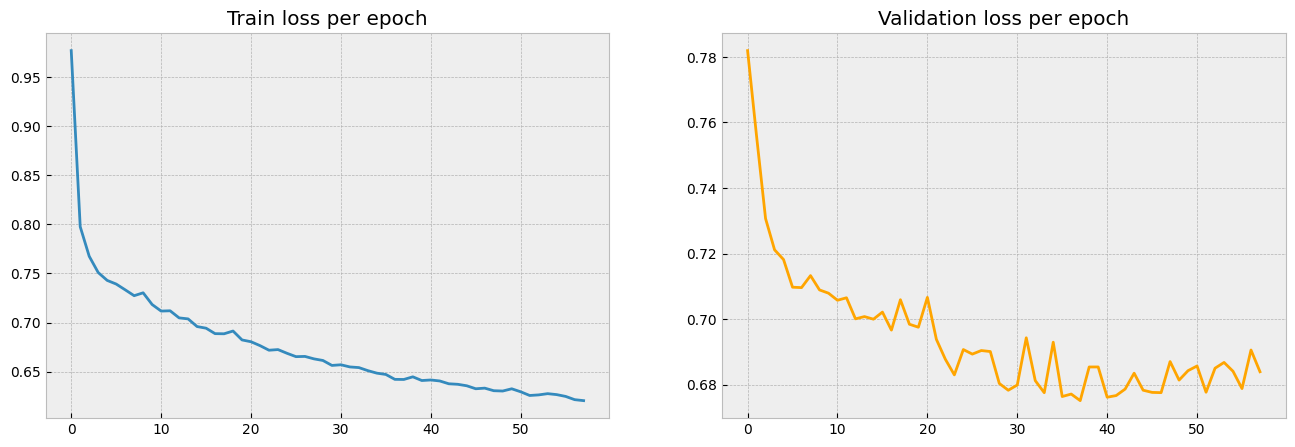

MSE:
	Train loss: 0.621
	Val loss:   0.684


In [ ]:

plot_training_metrics(tfr_pos_cat_trainer.logger)

## Testing / Prediction

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE loss (sklearn), unscaled: 6.00


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


<Figure size 1800x700 with 0 Axes>

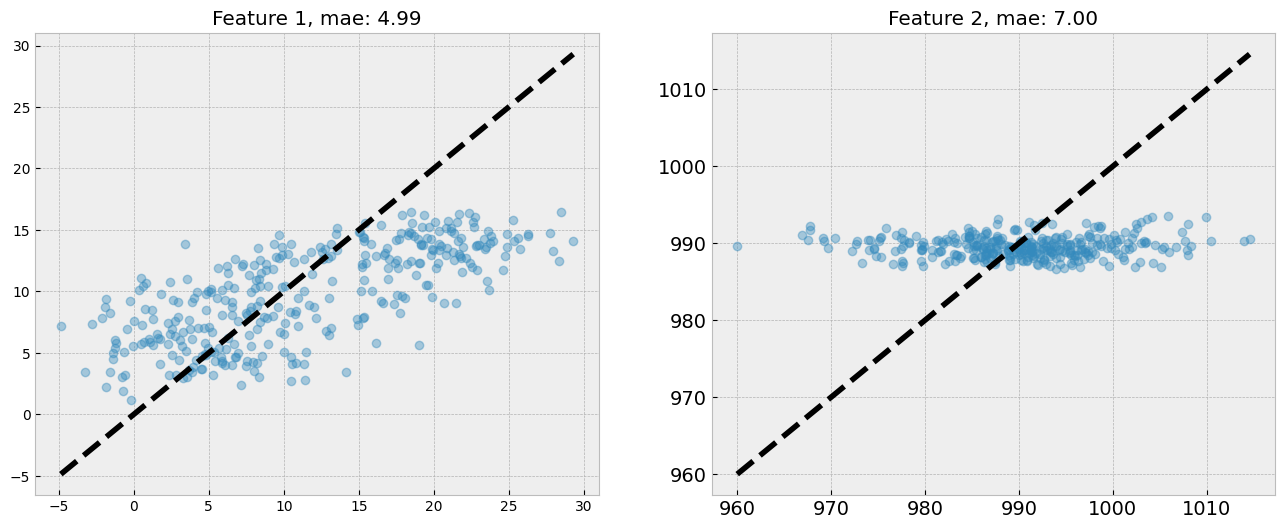

In [ ]:
_, y = map(torch.cat, zip(*tfr_pos_cat_dm.test_dataloader()))
y_hat = torch.cat(tfr_pos_cat_trainer.predict(tfr_pos_cat_model, tfr_pos_cat_dm))
plot_test_predict(y[:], y_hat[:], scaler=scaler, kind='scatter');
# np.mean(np.abs(y.numpy() - y_hat.numpy()))

# Conclusion

This notebook provided a basic use-case for transformers applied to time-series data on simple multivariate time series. For a more advanced implementation, please refer to packages intentionally designed for such data crunching, e.g.:
- https://github.com/timeseriesAI/tsai/
- https://github.com/jdb78/pytorch-forecasting